In [1]:
!pip install tensorflow

In [2]:
import boto3
from pyathena import connect
import pandas as pd
import os
import base64
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('.'):
    print(dirname)

.
./.sagemaker_sql_editor_api_cache
./.local
./.local/share
./.local/share/jupyter
./.local/share/jupyter/runtime
./.local/share/jupyter/jupyter_ai
./.local/share/jupyter/jupyter_ai/indices
./.ipython
./.ipython/profile_default
./.ipython/profile_default/security
./.ipython/profile_default/log
./.ipython/profile_default/startup
./.ipython/profile_default/pid
./.ipython/profile_default/db
./.npm
./.npm/_logs
./.jupyter
./.jupyter/lab
./.jupyter/lab/user-settings
./.jupyter/lab/user-settings/@jupyter-lsp
./.jupyter/lab/user-settings/@jupyter-lsp/jupyterlab-lsp
./.jupyter/lab/user-settings/@jupyterlab
./.jupyter/lab/user-settings/@jupyterlab/completer-extension
./.jupyter/lab/workspaces
./.ipynb_checkpoints
./.cache
./.cache/YAPF
./.cache/YAPF/0.43.0
./.cache/jedi
./.cache/jedi/CPython-312-33
./.cache/pip
./.cache/pip/http-v2
./.cache/pip/http-v2/a
./.cache/pip/http-v2/a/1
./.cache/pip/http-v2/a/1/9
./.cache/pip/http-v2/a/1/9/5
./.cache/pip/http-v2/a/1/9/5/3
./.cache/pip/selfcheck
./.cach

In [ ]:
region = 'us-east-2'  
s3_staging_dir = 's3://tc3-postech-fiap-upda/athena-results/'  
conn = connect(
    s3_staging_dir=s3_staging_dir,
    region_name=region
)

query = """
SELECT *
FROM "tc3-database"."base_de_imagens"
"""

df = pd.read_sql(query, conn)
df.head()

In [ ]:
for idx, item in df.iterrows():
    os.makedirs(f'/home/sagemaker-user/music_instruments/{item['instrumento']}', exist_ok=True)

    if ',' in item['imagem']:
        item['imagem'] = item['imagem'].split(',')[1]

    imagem_bytes = base64.b64decode(item['imagem'])

    # Salva como jpg
    with open(f'/home/sagemaker-user/music_instruments/{item['instrumento']}/imagem{idx}.jpg', 'wb') as f:
        f.write(imagem_bytes)

In [3]:
import tensorflow as tf

train_ds,test_ds = tf.keras.utils.image_dataset_from_directory(
    '/home/sagemaker-user/music_instruments/',
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"
)
class_names=train_ds.class_names

2025-05-24 20:31:16.527023: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 1806 files belonging to 10 classes.
Using 1445 files for training.
Using 361 files for validation.


In [4]:
train_dataset=train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(buffer_size=1000)
test_a_dataset=test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [5]:
from tensorflow.keras.applications import EfficientNetB3

base_model = EfficientNetB3(
    weights='imagenet',  
    input_shape=(224, 224, 3),
    include_top=False    
)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])


inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)        
x = base_model(x, training=False)        
x = tf.keras.layers.GlobalAveragePooling2D()(x)    
x = tf.keras.layers.Dense(512, activation='relu')(x)  
x = tf.keras.layers.Dense(10, activation='softmax')(x) 

final_model = tf.keras.models.Model(inputs=inputs, outputs=x)

final_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,575,609 (44.16 MB)

 Trainable params: 11,488,306 (43.82 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [6]:
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,  
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=3, 
    min_lr=1e-7
)


class StopOnValAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target=0.985):
        super().__init__()
        self.target = target

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        if val_acc is not None and val_acc >= self.target:
            print(f"\nReached {val_acc:.2%} val_accuracy — stopping training.")
            self.model.stop_training = True

In [8]:
history = final_model.fit(
    train_dataset,
    validation_data=test_a_dataset,
    epochs=100,
    callbacks=[early_stopping, reduce_lr,StopOnValAccuracy(target=0.980)]
)

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 319s 6s/step - accuracy: 0.6183 - loss: 1.2236 - val_accuracy: 0.7036 - val_loss: 1.4939 - learning_rate: 0.0010
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 255s 6s/step - accuracy: 0.8113 - loss: 0.6688 - val_accuracy: 0.7867 - val_loss: 0.9132 - learning_rate: 0.0010
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 254s 6s/step - accuracy: 0.8794 - loss: 0.4297 - val_accuracy: 0.8421 - val_loss: 0.4921 - learning_rate: 0.0010
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 255s 6s/step - accuracy: 0.8932 - loss: 0.3724 - val_accuracy: 0.8615 - val_loss: 0.6414 - learning_rate: 0.0010
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 254s 6s/step - accuracy: 0.9214 - loss: 0.2943 - val_accuracy: 0.8338 - val_loss: 0.5219 - learning_rate: 0.0010
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 254s 6s/step - accuracy: 0.9235 - loss: 0.2649 - val_accuracy: 0.8033 - val_loss: 0.7969 - learning_rate: 0.0010
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 254s 6s/step - accuracy: 0.9323 - loss: 0.1895 - 

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = []
y_pred_probs = []

for images, labels in test_a_dataset:
    y_true.extend(labels.numpy())
    y_pred_probs.extend(final_model.predict(images, verbose=0))

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# Check if labels are one-hot encoded
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

y_pred = np.argmax(y_pred_probs, axis=1)

report = classification_report(
    y_true,
    y_pred,
    digits=4
)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.8485    0.9180        33
           1     0.8919    0.9706    0.9296        34
           2     0.9600    1.0000    0.9796        48
           3     0.8000    0.9143    0.8533        35
           4     0.9722    0.8974    0.9333        39
           5     0.9062    0.9667    0.9355        30
           6     0.9412    0.8889    0.9143        36
           7     0.9024    0.9024    0.9024        41
           8     0.9677    0.9677    0.9677        31
           9     0.9688    0.9118    0.9394        34

    accuracy                         0.9280       361
   macro avg     0.9310    0.9268    0.9273       361
weighted avg     0.9317    0.9280    0.9283       361



2025-05-24 22:06:52.972406: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-05-24 22:07:06.549862: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


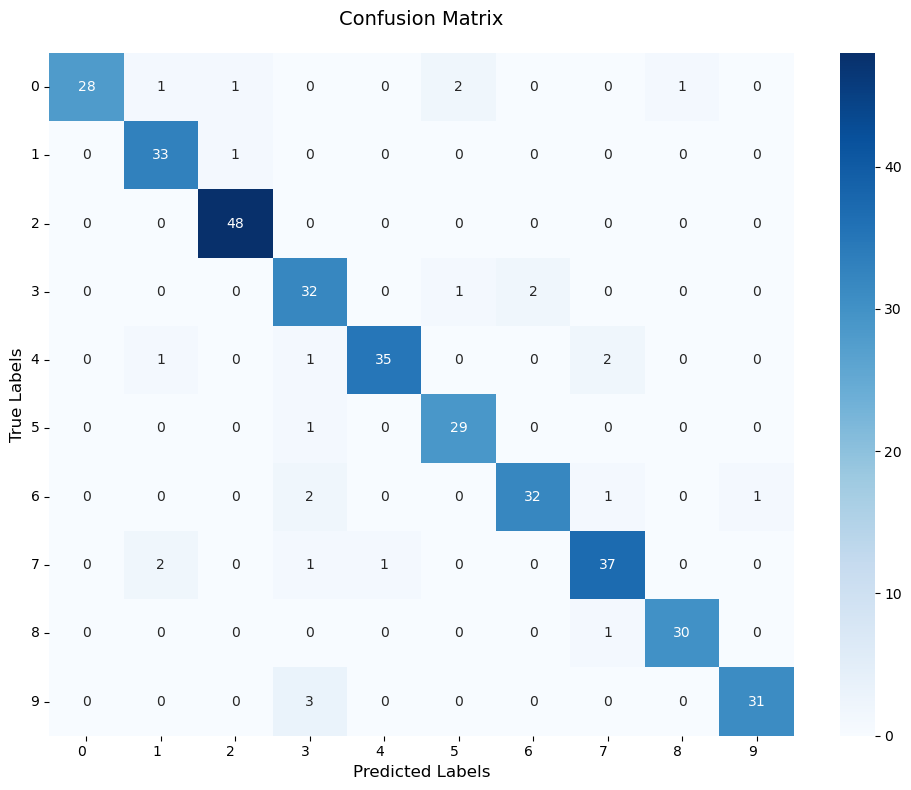

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    """
    Plots a beautiful confusion matrix with annotations
    
    Args:
        y_true: Array of true labels
        y_pred: Array of predicted labels
        class_names: List of class names
    """

    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',)
    
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14, pad=20)
    
    plt.xticks(rotation=0, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

y_true = []
y_pred = []

for images, labels in test_a_dataset:
    if len(labels.shape) > 1: 
        y_true.extend(np.argmax(labels.numpy(), axis=1))
    else:
        y_true.extend(labels.numpy())
    
    preds = final_model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))


plot_confusion_matrix(y_true, y_pred, )

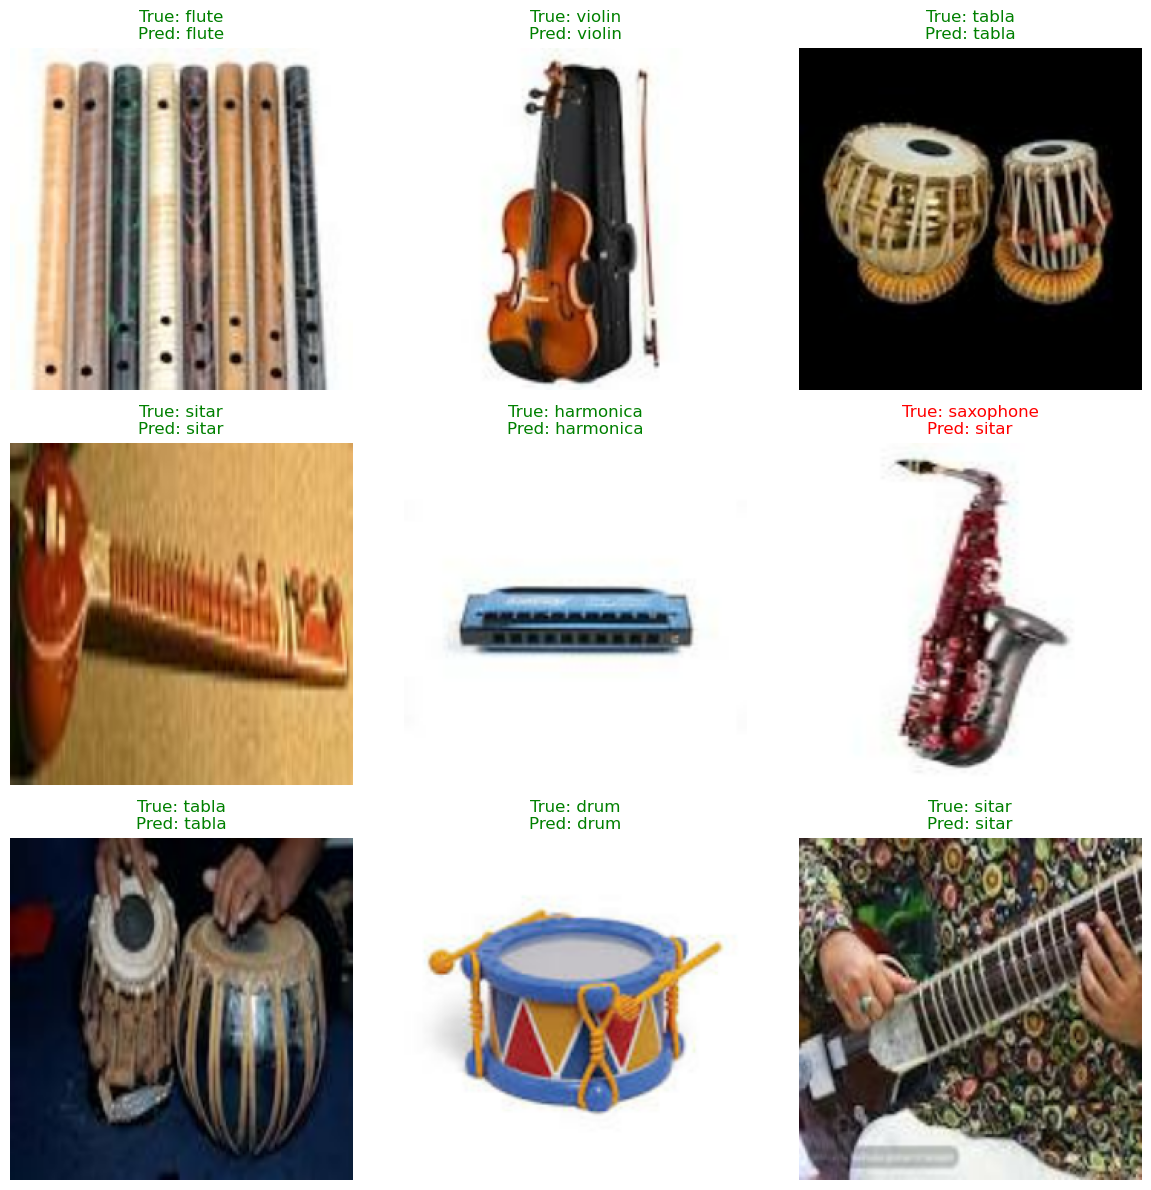

In [11]:
def plot_predictions(model, dataset, class_names, num_images=9):
    """
    Plots images with their true and predicted labels
    
    Args:
        model: Trained Keras model
        dataset: TensorFlow dataset (batched)
        class_names: List of class names
        num_images: Number of images to display (default 9)
    """
    plt.figure(figsize=(12, 12))
    
    for images, labels in dataset.take(1):
        preds = final_model.predict(images, verbose=0)
        pred_classes = np.argmax(preds, axis=1)
        

        if len(labels.shape) > 1:
            true_classes = np.argmax(labels.numpy(), axis=1)
        else:
            true_classes = labels.numpy()
        
        for i in range(min(num_images, len(images))):
            ax = plt.subplot(3, 3, i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            
            true_label = class_names[true_classes[i]]
            pred_label = class_names[pred_classes[i]]
            
            color = 'green' if true_label == pred_label else 'red'
            plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()

plot_predictions(final_model, test_a_dataset, class_names)

In [16]:
import pickle
import boto3

In [14]:
with open('/home/sagemaker-user/instruments.pickle', 'wb') as f:
        pickle.dump(final_model, f)

In [22]:
s3_bucket="tc3-postech-fiap-upda"
s3_key="model/instruments.pickle"

In [25]:

s3 = boto3.client('s3')
s3.upload_file('/home/sagemaker-user/instruments.pickle', s3_bucket, s3_key)
